# QUANTUM CHEMISTRY

### 1. IMPORTAR LES LLIBRERIES QUE UTILITZAREM

In [1]:
%matplotlib inline

In [33]:
!pip3 install pennylane

In [3]:
import sys
from pennylane import numpy as np
from pennylane import qchem

### 2. DEFINIR LES ESTRUCTURES MOLECULARS QUE VOLEM ESTUDIAR
Això ho podem fer a mà com en el nostre cas o bé llegir un fitxer tipus .xyz
El meu subte principal és si s'hauria de considerar calcular el Hamiltonia per a HCOOH o bé per a -COOH.
La primera forma és com la trobem en la natura interccionant amb aigua, la segona seria com si arrenquessim el grup carboxilic d'un aminoàcid, cosa que no se fins a quin punt és realista. 

In [4]:
symbols = ["C", "O", "O", "H", "H"] #no he trobat les coordenades atòmiques de COOH-
#analitzare HCOOH tenint en compte que aquesta molècula en aigua es dissocia a H3O + COOH-
coordinates = np.array([0.0,0.4220,0.0,-1.0338,-0.4353,0.0,1.1587,0.1022,0.0,-0.3512,1.4612,0.0,-0.6482,-1.3276,0.0]) #referencia [1]
#symbols, coordinates = qchem.read_structure("HCOOH.xyz") (no he trobat cap fitxer així)

### 3. CÀLCUL DEL HAMILTONIÀ DE LA MOLÈCULA

In [5]:
#H, qubits = qchem.molecular_hamiltonian(symbols, coordinates) #aquesta funcio el que fa es agafar el circuit quantic proposat
# i construir el seu hamiltonia
#print("Number of qubits: {:}".format(qubits)) #retorna el numero de qubits necessaris i el hamiltonia
#print("Qubit Hamiltonian")
#print(H) 
#no he aconseguit aquest pas perquè triga massa

Passos que segueix la funció qchem.molecular_hamiltonian:
1. S'utilitza el mètode de Hartree-Fock que el que fa es tractar cada electró del sistema com a una partícula independent que es mou depenent del sistema. 
2. Aquestes equacions de moviment es poden resoldre per acabar-les expressant en forma del Hamiltoniá de la molècula: combinació lineal dels de coeficients escalars + element de Pauli {I,X,Y,Z}.
Com que agafar tots els electrons és massa costós computacionalment anem a modificar alguns paràmetres per tal de reduir el nombre de qubits necessaris i poder així resoldre el Hamiltonià de la molècula.


### 2.1. Modificar paràmetres avançats per facilitar el càlcul 

In [6]:
charge = 0 #per molecules neutres com HCOOH

In [7]:
multiplicity = 1 # 2S + 1 = 1, tenim tots els orbitals ocupats menys un electró desaparellat (S)

In [8]:
basis_set = "sto-3g" #type of gaussian atomic base

In [9]:
#definim els diferents electrons que tenim i ens quedem només amb els actius per reduir el numero de qubits
electrons = 18 # estructura de lewis, electrons de valencia
orbitals = 18 #orbitals que tenim per separat suman els de cada àtom de la molècula
core, active = qchem.active_space(electrons, orbitals, active_electrons=4, active_orbitals=4)
#agafo quatre orbitals com actius perquè la molècula es troba en hibridació sp3
#electrons actius agafo 2 perquè els enllaços es fan de dos en dos

In [10]:
print("List of core orbitals: {:}".format(core))
print("List of active orbitals: {:}".format(active))
print("Number of qubits: {:}".format(2 * len(active)))

List of core orbitals: [0, 1, 2, 3, 4, 5, 6]
List of active orbitals: [7, 8, 9, 10]
Number of qubits: 8


In [11]:
H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    active_electrons=4,
    active_orbitals=4,
)

print("Number of qubits required to perform quantum simulations: {:}".format(qubits))
print("Hamiltonian of the water molecule")
print(H)

Number of qubits required to perform quantum simulations: 8
Hamiltonian of the water molecule
  (-176.5715658917871) [I0]
+ (-0.4797162540295981) [Z6]
+ (-0.4797162540295981) [Z7]
+ (-0.21852932672297185) [Z5]
+ (-0.21852932672297168) [Z4]
+ (0.14500132623147405) [Z2]
+ (0.14500132623147421) [Z3]
+ (0.19695012802234044) [Z0]
+ (0.19695012802234044) [Z1]
+ (0.007131929436487463) [Y0 Y2]
+ (0.007131929436487463) [X0 X2]
+ (0.007426138618066883) [Y1 Y3]
+ (0.007426138618066883) [X1 X3]
+ (0.09265483489855587) [Z2 Z6]
+ (0.09265483489855587) [Z3 Z7]
+ (0.09853350466442136) [Z2 Z7]
+ (0.09853350466442136) [Z3 Z6]
+ (0.10311735666180594) [Z4 Z6]
+ (0.10311735666180594) [Z5 Z7]
+ (0.10745801582666592) [Z4 Z7]
+ (0.10745801582666592) [Z5 Z6]
+ (0.11150040339173431) [Z0 Z6]
+ (0.11150040339173431) [Z1 Z7]
+ (0.11749119775785011) [Z0 Z7]
+ (0.11749119775785011) [Z1 Z6]
+ (0.12187239575780615) [Z0 Z2]
+ (0.12187239575780615) [Z1 Z3]
+ (0.13232145759913214) [Z0 Z4]
+ (0.13232145759913214) [Z1 Z5]


### 3. Variational Quantum Eigensolver (VQE)

Algoritme utilitzat per donar la ground state energy d'una molècula donat el seu Hamiltonià.



In [1]:
import pickle
with open("C:\\Users\\lclai\\Desktop\\LDIG\\DB\\hamiltonians\\hamiltonian.pkl", "rb") as f:
    H = pickle.load(f)

In [3]:
import pennylane as qml
from pennylane import numpy as np

kwargs_mps = {
    # Maximum bond dimension of the MPS
    "max_bond_dim": 50,
    # Cutoff parameter for the singular value decomposition
    "cutoff": np.finfo(np.complex128).eps,
    # Contraction strategy to apply gates
    "contract": "auto-mps",
}
#dev = qml.device("default.qubit", wires=qubits)
dev = qml.device("default.tensor", method="mps", **kwargs_mps)

#dev = qml.device("default.qubit", wires = qubits)
print(dev)

<default.tensor device at 0x1c312962da0>


In [9]:
electrons = 2 #agafem només els que hem considerat com actius (?)
qubits = 8
hf = qml.qchem.hf_state(electrons,qubits)
print(hf)

[1 1 0 0 0 0 0 0]


In [4]:
def circuit(param,wires):
    qml.BasisState(hf, wires = wires)
    qml.DoubleExcitation(param,wires = [0,1,2,3]) #he posat 4 perque sino la error function em dona error pero no entenc perque no son 8

In [6]:
@qml.qnode(dev, interface = "autograd")
def cost_fn(param):
    circuit(param,wires = range(qubits))
    return qml.expval(H)

In [5]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

In [17]:
#import torch
#tensor1 = torch.tensor([0.0],requires_grad=True)
#tensor1 = tensor1.detach().numpy()

In [7]:
from pennylane import numpy as np
theta = np.array(0.0, requires_grad = True)

In [10]:
energy = [cost_fn(theta)]

c:\Users\lclai\miniconda3\envs\house\lib\site-packages\pennylane\ops\qubit\hamiltonian.py:257: PennyLaneDeprecationWarning: Using 'qml.ops.Hamiltonian' with new operator arithmetic is deprecated. Instead, use 'qml.Hamiltonian'. Please visit https://docs.pennylane.ai/en/stable/news/new_opmath.html for more information and help troubleshooting.
  warn(
c:\Users\lclai\miniconda3\envs\house\lib\site-packages\pennylane\devices\default_tensor.py:678: ComplexWarning: Casting complex values to real discards the imaginary part
  str(int(b)) for b in op.parameters[0].astype(self._c_dtype)


MemoryError: Unable to allocate 8.00 GiB for an array with shape (2, 536870912) and data type float64

In [ ]:
# store the values of the circuit parameter
angle = [theta]

max_iterations = 20
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    #if conv <= conv_tol:
       # break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")
energy_carboxi = energy[-1]
print(energy_carboxi)

Step = 0,  Energy = -177.59487958 Ha
Step = 2,  Energy = -177.59571489 Ha
Step = 4,  Energy = -177.59644615 Ha
Step = 6,  Energy = -177.59708591 Ha
Step = 8,  Energy = -177.59764533 Ha
Step = 10,  Energy = -177.59813427 Ha
Step = 12,  Energy = -177.59856142 Ha
Step = 14,  Energy = -177.59893447 Ha
Step = 16,  Energy = -177.59926016 Ha
Step = 18,  Energy = -177.59954442 Ha

Final value of the ground-state energy = -177.59967267 Ha

Optimal value of the circuit parameter = 0.1435
-177.599672670902


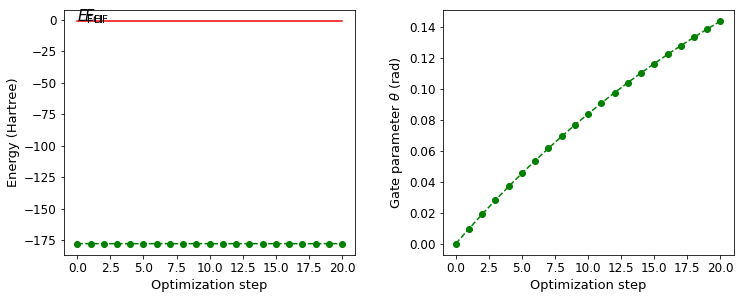

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show() #ara si que funciona el gradient l'unic que varia molt poc i sembla que estigui recte

In [2]:
pip install pymol

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pymol (from versions: none)
ERROR: No matching distribution found for pymol


In [1]:
# glycine_pymol.py
from pymol import cmd

cmd.reinitialize()

# Define the atomic coordinates and elements
glycine = [
    ('C', [0.000000, 0.000000, 0.000000]),
    ('C', [1.333899, 0.000000, 0.000000]),
    ('N', [-0.715903, 0.928466, 0.000000]),
    ('O', [2.049494, -0.928466, 0.000000]),
    ('O', [2.049494, 0.928466, 0.000000]),
    ('H', [-0.689394, 1.692445, -0.913520]),
    ('H', [-0.689394, 1.692445, 0.913520]),
    ('H', [1.342715, -0.655143, 0.930884]),
    ('H', [1.342715, -0.655143, -0.930884]),
    ('H', [2.049494, -1.692445, 0.000000]),
    ('H', [2.049494, 1.692445, 0.000000])
]

# Add atoms to PyMOL
for i, (element, coord) in enumerate(glycine):
    cmd.pseudoatom(f'atom{i}', elem=element, pos=coord)

cmd.group('glycine', 'atom*')
cmd.show('spheres', 'glycine')
cmd.save('glycine.pse')
cmd.png('glycine.png', width=800, height=600, dpi=300)


ModuleNotFoundError: No module named 'pymol'

### REFERÈNCIES

https://cccbdb.nist.gov/expgeom2.asp?casno=64186&charge=0

In [22]:
#fare el mateix pel grup H3N (desaparellat)

symbols = ["N", "H", "H", "H"] 
coordinates = np.array([0,0,0,0,-0.9366,-0.3816,0.8121,0.4689,-0.3816,-0.8121,0.4689,-0.3816]) #referencia [2]

#charge i multiplicity definits abans i son iguals

electrons = 8 
orbitals = 8
core, active = qchem.active_space(electrons, orbitals, active_electrons=4, active_orbitals=4)


print("List of core orbitals: {:}".format(core))
print("List of active orbitals: {:}".format(active))
print("Number of qubits: {:}".format(2 * len(active)))

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    active_electrons=4,
    active_orbitals=4,
)

print("Number of qubits required to perform quantum simulations: {:}".format(qubits))
print("Hamiltonian of the water molecule")
print(H)


List of core orbitals: [0, 1]
List of active orbitals: [2, 3, 4, 5]
Number of qubits: 8


Number of qubits required to perform quantum simulations: 8
Hamiltonian of the water molecule
  (-49.355248443906106) [I0]
+ (-0.5289993691159448) [Z6]
+ (-0.5289993691159448) [Z7]
+ (-0.4824685794626965) [Z4]
+ (-0.4824685794626964) [Z5]
+ (0.25129571416006236) [Z3]
+ (0.25129571416006247) [Z2]
+ (0.39441251333847105) [Z0]
+ (0.3944125133384711) [Z1]
+ (-0.006692900004318134) [Y3 Y5]
+ (-0.006692900004318134) [X3 X5]
+ (-1.131383875474512e-11) [Y5 Y7]
+ (-1.131383875474512e-11) [X5 X7]
+ (-1.9321354954339454e-12) [Y0 Y2]
+ (-1.9321354954339454e-12) [X0 X2]
+ (0.009473334241173383) [Y2 Y4]
+ (0.009473334241173383) [X2 X4]
+ (0.11053446128824063) [Z4 Z6]
+ (0.11053446128824063) [Z5 Z7]
+ (0.11496275054723862) [Z2 Z4]
+ (0.11496275054723862) [Z3 Z5]
+ (0.11696721379226771) [Z4 Z5]
+ (0.12306083877226082) [Z0 Z4]
+ (0.12306083877226082) [Z1 Z5]
+ (0.12554471563143527) [Z2 Z5]
+ (0.12554471563143527) [Z3 Z4]
+ (0.1280984356916759) [Z4 Z7]
+ (0.1280984356916759) [Z5 Z6]
+ (0.130812793523327

https://cccbdb.nist.gov/exp2x.asp?casno=7664417&charge=0

In [23]:
@qml.qnode(dev, interface = "autograd")
def cost_fn(param):
    circuit(param,wires = range(qubits))
    return qml.expval(H)
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 20
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    #if conv <= conv_tol:
       # break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")
energy_amoni = energy[-1]
print(energy_amoni)

Step = 0,  Energy = -51.18009434 Ha
Step = 2,  Energy = -51.18009539 Ha
Step = 4,  Energy = -51.18009621 Ha
Step = 6,  Energy = -51.18009683 Ha
Step = 8,  Energy = -51.18009731 Ha
Step = 10,  Energy = -51.18009767 Ha
Step = 12,  Energy = -51.18009795 Ha
Step = 14,  Energy = -51.18009817 Ha
Step = 16,  Energy = -51.18009834 Ha
Step = 18,  Energy = -51.18009846 Ha

Final value of the ground-state energy = -51.18009852 Ha

Optimal value of the circuit parameter = 0.1393
-51.18009851559546


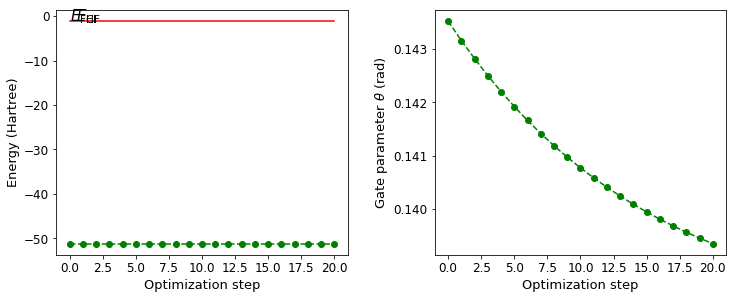

In [24]:

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show() #ara si que funciona el gradient

In [25]:
#fem el mateix pel H sol

symbols = ["H","H"] 
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614]) 
orbitals = 2
electrons = 2

H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

dev = qml.device("default.qubit", wires=qubits)
print(dev)

electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    
@qml.qnode(dev, interface="autograd")
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

opt = qml.GradientDescentOptimizer(stepsize=0.4)

theta = np.array(0.0, requires_grad=True)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")
energy_hidrogen = energy[-1]

Number of qubits =  4
The Hamiltonian is    (-0.24274501260941428) [Z2]
+ (-0.24274501260941428) [Z3]
+ (-0.04207255194743942) [I0]
+ (0.1777135822909175) [Z1]
+ (0.17771358229091755) [Z0]
+ (0.12293330449299367) [Z0 Z2]
+ (0.12293330449299367) [Z1 Z3]
+ (0.1676833885560136) [Z0 Z3]
+ (0.1676833885560136) [Z1 Z2]
+ (0.17059759276836814) [Z0 Z1]
+ (0.17627661394181804) [Z2 Z3]
+ (-0.04475008406301995) [Y0 Y1 X2 X3]
+ (-0.04475008406301995) [X0 X1 Y2 Y3]
+ (0.04475008406301995) [Y0 X1 X2 Y3]
+ (0.04475008406301995) [X0 Y1 Y2 X3]
Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.31.0
Author: Xanadu Inc.
Wires: 4
Shots: None
[1 1 0 0]
Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal valu

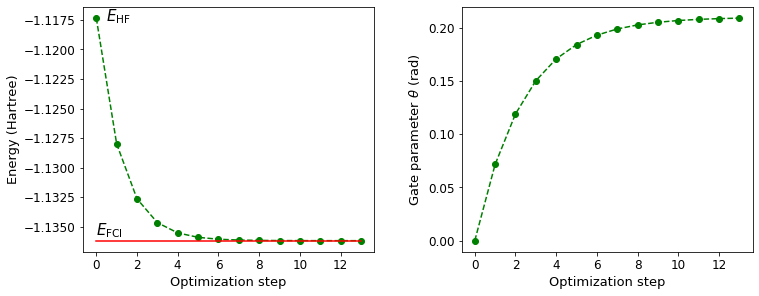

In [26]:

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In [27]:
data = {
    'Ground_state_energy': [energy_hidrogen, energy_carboxi, energy_amoni],
    'Electrones': [2, 18, 10]
}
import pandas as pd
df = pd.DataFrame(data)

# Asignamos nombres a los índices
df.index = ['H2', 'HCOOH', 'NH3']

print(df)

       Ground_state_energy  Electrones
H2     -1.1361888285450756           2
HCOOH    -177.599672670902          18
NH3     -51.18009851559546          10


In [28]:
energy_structure_aminoacid = (1/(df['Electrones'].sum()))*(df['Ground_state_energy'].multiply(df['Electrones'], axis=0).sum())
energy_structure_aminoacid

-123.69558236297603

In [29]:
df['Ground_state_energy'].sum()

tensor(-229.91596002, requires_grad=True)

PER OXIGEN

In [30]:
symbols = ["O","O"] 
coordinates = np.array([0,0,0,0,0,1.2075])

#charge i multiplicity definits abans i son iguals

electrons = 8 
orbitals = 8
core, active = qchem.active_space(electrons, orbitals, active_electrons=4, active_orbitals=4)


print("List of core orbitals: {:}".format(core))
print("List of active orbitals: {:}".format(active))
print("Number of qubits: {:}".format(2 * len(active)))

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    active_electrons=4,
    active_orbitals=4,
)

print("Number of qubits required to perform quantum simulations: {:}".format(qubits))
print("Hamiltonian of the water molecule")
print(H)

List of core orbitals: [0, 1]
List of active orbitals: [2, 3, 4, 5]
Number of qubits: 8
Number of qubits required to perform quantum simulations: 8
Hamiltonian of the water molecule
  (-139.86768494409418) [I0]
+ (-1.525893330311391) [Z6]
+ (-1.5258933303113906) [Z7]
+ (-0.18760721068654665) [Z2]
+ (-0.18760721068654665) [Z3]
+ (-0.18760721068653846) [Z4]
+ (-0.18760721068653835) [Z5]
+ (0.2390482146854385) [Z0]
+ (0.2390482146854386) [Z1]
+ (0.155489440201515) [Z0 Z4]
+ (0.155489440201515) [Z1 Z5]
+ (0.15548944020154648) [Z0 Z2]
+ (0.15548944020154648) [Z1 Z3]
+ (0.16058214613899685) [Z0 Z6]
+ (0.16058214613899685) [Z1 Z7]
+ (0.1666180794658645) [Z2 Z4]
+ (0.1666180794658645) [Z3 Z5]
+ (0.16916736358777565) [Z0 Z5]
+ (0.16916736358777565) [Z1 Z4]
+ (0.16916736358780987) [Z0 Z3]
+ (0.16916736358780987) [Z1 Z2]
+ (0.1745501619369051) [Z2 Z5]
+ (0.1745501619369051) [Z3 Z4]
+ (0.1780804678087377) [Z4 Z6]
+ (0.1780804678087377) [Z5 Z7]
+ (0.1780804678087754) [Z2 Z6]
+ (0.1780804678087754) 

In [31]:
dev = qml.device("default.qubit", wires=qubits)
print(dev)


hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    
@qml.qnode(dev, interface="autograd")
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

opt = qml.GradientDescentOptimizer(stepsize=0.4)

theta = np.array(0.0, requires_grad=True)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 20
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    #if conv <= conv_tol:
     #   break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")
energy_hidrogen = energy[-1]

Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.31.0
Author: Xanadu Inc.
Wires: 8
Shots: None
[1 1 1 1 1 1 1 1]
Step = 0,  Energy = -131.60757035 Ha
Step = 2,  Energy = -131.60757035 Ha
Step = 4,  Energy = -131.60757035 Ha
Step = 6,  Energy = -131.60757035 Ha
Step = 8,  Energy = -131.60757035 Ha
Step = 10,  Energy = -131.60757035 Ha
Step = 12,  Energy = -131.60757035 Ha
Step = 14,  Energy = -131.60757035 Ha
Step = 16,  Energy = -131.60757035 Ha
Step = 18,  Energy = -131.60757035 Ha

Final value of the ground-state energy = -131.60757035 Ha

Optimal value of the circuit parameter = 0.0000


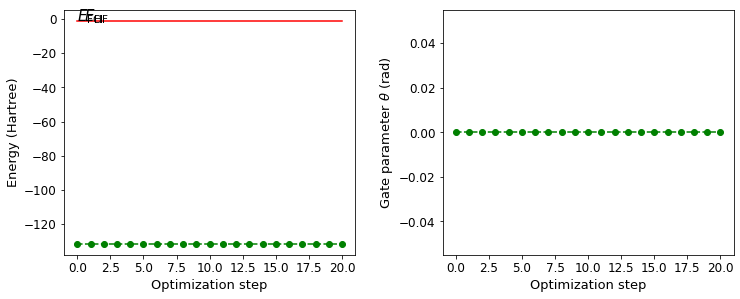

In [32]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()